100%|██████████| 3/3 [00:00<00:00, 22795.13it/s]


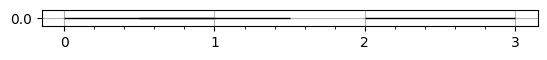

In [1]:
from large_gcs.geometry.polyhedron import Polyhedron
import numpy as np

from large_gcs.graph.cost_constraint_factory import (
    create_2d_x_equality_edge_constraint,
    create_2d_y_equality_edge_constraint,
    create_l1norm_edge_cost,
)
from large_gcs.graph.graph import DefaultGraphCostsConstraints, Edge, Graph
from large_gcs.algorithms.search_algorithm import SearchNode
from large_gcs.domination_checkers.ah_containment_domination_checker import (
    AHContainmentDominationChecker,
)


def create_simple_1d_graph() -> Graph:
    dim = 1
    # Convex sets
    sets = (
        # s
        Polyhedron.from_vertices([[0], [1]]),
        # t
        Polyhedron.from_vertices([[2], [3]]),
        # p0
        Polyhedron.from_vertices([[0.5], [1.5]]),
    )

    # Vertex names
    vertex_names = ["s", "t"]
    vertex_names += [f"p{i}" for i in range(len(sets) - 2)]

    # Edge costs
    # edge_cost = create_l2norm_squared_edge_cost(dim)
    edge_cost = create_l1norm_edge_cost(dim)
    default_costs_constraints = DefaultGraphCostsConstraints(edge_costs=[edge_cost])
    # Add convex sets to graph
    G = Graph(default_costs_constraints)
    G.add_vertices_from_sets(sets, names=vertex_names)
    G.set_source("s")
    G.set_target("t")

    # Edges
    hor_edges = {
        "s": ("t",),
        "p0": ("t",),
    }

    def add_edges(edges, constraints):
        for u, vs in edges.items():
            for v in vs:
                # print(f"Adding edge {u} -> {v}")
                G.add_edge(Edge(u, v, constraints=constraints))

    add_edges(hor_edges, None)
    return G


G = create_simple_1d_graph()
G.plot_sets()
# G.plot_edges()
# G.plot_set_labels()
import matplotlib.pyplot as plt

# Setting major and minor ticks
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(plt.MultipleLocator(1))  # Major ticks at every 1
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))  # Minor ticks at every 0.2
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.grid()

In [2]:
domination_checker = AHContainmentDominationChecker(graph=G)

n = SearchNode.from_vertex_path(["s", "t"])
n_prime = SearchNode.from_vertex_path(["p0", "t"])
A_n, b_n = domination_checker.get_epigraph_matrices(
    n, cost_upper_bound=5, add_upper_bound=False
)
T_n = domination_checker.get_projection_transformation(
    G, n, total_dims=A_n.shape[1], include_cost_epigraph=True
)
A_n_prime, b_n_prime = domination_checker.get_epigraph_matrices(
    n_prime, cost_upper_bound=5, add_upper_bound=False
)
T_n_prime = domination_checker.get_projection_transformation(
    G, n_prime, total_dims=A_n_prime.shape[1], include_cost_epigraph=True
)

X.A(): [[ 1.  0.  0.]
 [-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0. -1.  0.]
 [ 1. -1. -1.]
 [-1.  1. -1.]]
X.b(): [ 1. -0.  3. -2.  0.  0.]
X.A(): [[ 1.  0.  0.]
 [-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0. -1.  0.]
 [ 1. -1. -1.]
 [-1.  1. -1.]]
X.b(): [ 1.5 -0.5  3.  -2.   0.   0. ]


In [3]:
G.vertices["t"].convex_set.set.A()

array([[ 1.],
       [-1.]])

In [4]:
A_n, b_n, T_n

(array([[ 1.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 1., -1., -1.,  0.],
        [-1.,  1., -1.,  0.],
        [ 0.,  0.,  1., -1.]]),
 array([ 1., -0.,  3., -2.,  0.,  0.,  0.]),
 array([[0., 1., 0., 0.],
        [0., 0., 0., 1.]]))

In [5]:
T_n.shape, A_n.shape

((2, 4), (7, 4))

In [6]:
np.arange(A_n.shape[1]).reshape(-1, 1)

array([[0],
       [1],
       [2],
       [3]])

In [7]:
T_n @ np.arange(A_n.shape[1]).reshape(-1, 1)

array([[1.],
       [3.]])

In [8]:
T_n_prime @ np.arange(A_n_prime.shape[1]).reshape(-1, 1)

array([[1.],
       [3.]])

In [9]:
P_n_prime = Polyhedron(A=A_n_prime, b=b_n_prime)
P_n_prime.plot_transformation(T_n_prime, color="b", linestyle="dashed")
P_n = Polyhedron(A=A_n, b=b_n)
P_n.plot_transformation(T_n, color="r", linestyle="dotted")
G.plot_sets()

SystemExit: Failure at geometry/optimization/vpolytope.cc:120 in VPolytope(): condition 'hpoly.IsBounded()' failed.

/home/shaoyuan/Documents/Software/large_gcs/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [10]:
domination_checker.is_contained_in(A_n, b_n, T_n, A_n_prime, b_n_prime, T_n_prime)
# Should return True

True

In [11]:
domination_checker.is_contained_in(A_n_prime, b_n_prime, T_n_prime, A_n, b_n, T_n)
# Should return False

False